# Plot Strava Data
This Jupyer notebook plots your Strava data in some interesting ways

## Import required packages

In [1]:
# conda install -c conda-forge gpxpy
import gzip
import os
import gpxpy
import gpxpy.gpx
import glob
import os
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Define user settings
Below are settings used by the code to work out what type of visualisation to perform

In [2]:
# Which activities to include/exclude (this is the complete list of activities Strava includes)
include_run = True
include_ride = False 
include_swim = False 
include_workout = False 
include_hike = False 
include_walk = False 
include_nordicski = False 
include_alpineski = False 
include_backcountryski = False 
include_iceskate = False 
include_inlineskate = False 
include_kitesurf = False 
include_rollerski = False 
include_windsurf = False 
include_snowboard = False 
include_snowshoe = False 
include_ebikeride = False
include_virtualride = False 


title_date = True # Include the data of each activity in the title of each subplot
title_name = False # Include the activity name of each activity in the title of each subplot
# If both are false, no title will be added to the subplots

# You may wish to plot only a subset of your Strava data. 
# Define the starting and end date here. If you wish to plot
# all your data, set the starting (end) data to a ridiculously 
# early (late) data to ensure all your activities fall within 
# the data range
start_date = '01/01/2001'
end_date = '01/03/2020'


# Define directories to use
working_dir = 'D:/Users/Kirker/Google Drive/Git Repositories/PyplotStravaData/'
input_dir = working_dir + 'strava_input/' # Where the strava data is located
gpx_dir = input_dir + 'activities/' # where the .gpx files are located
output_dir = working_dir + 'output/' # Where to save copies of the figure(s) to

output_fig_name = 'my_activities.png' # define the file name for the figure to be saved as in the output_dir

# Choose the aspect ratio of the final graph.
asp_ratio = [16, 9] # width, height

In [3]:
# All my activities get saved to Strava. But often I want to only select a sub-sample of the 
# activities. For example, my running club runs on Tuesday nights at 7pm. I might want to plot 
# all our running routes, but I dont want to include my own personal training runs outside of 
# these in the figure.
#
# Below is a custom date filter to narrow down which activities to include. You can turn this off, 
# or adjust the filter to meet your needs

use_custom_act_filter = True

def custom_act_filter(act_df_row_in,use_custom_act_filter):
    # Given a row of a Pandas dataframe containing the detais of an individual activity, decide if activity should be plotted based on a custom filter
    
    if not use_custom_activity_filter:
        return True # Not using the filter, so always return True so activity is included
        
     # Else, the current code checks to see if the date and time of the activity match with what we want
        
    # get the date of the activity
    act_date = datetime.datetime.strptime(act_df_row_in['Activity Date'], '%b %d, %Y, %I:%M:%S %p')
        
    
    # Check if a activity takes place on a Tuesday
    if date_in.weekday() == 1:
        
        # Check time is after 6pm        
        if date_in > datetime.datetime(date_in.year, date_in.month, date_in.day, 18, 0, 0):
            return True
        else:
            return False
        
    else:
        return False

## Process user inputs
Take the user inputs and transform them into a form that will be useable in the code

In [4]:
# Construct a list of all the activity types that 
#should be included in the analysis
allowed_activities = []

strava_act_list = ['ride', 'run', 'swim', 'workout', 'hike', 'walk', 'nordicski', 'alpineski', 'backcountryski',
                   'iceskate', 'inlineskate', 'kitesurf', 'rollerski', 'windsurf', 'snowboard', 'snowshoe', 
                   'ebikeride', 'virtualride']

for indiv_act in strava_act_list:
    if eval('include_' + indiv_act): # if the activity is to be included (defined by user input), append to list
        allowed_activities.append(indiv_act)

    
    
print('The following activities will be included in the visualisation')    
print(allowed_activities)

The following activities will be included in the visualisation
['run']


## decompress GPX files
Strava stores the GPX files as .gz compressed files. Check the input directory for any, and if found, unzip them

In [5]:
gz_files_list = glob.glob(gpx_dir  + '*.gz') # list of all .gz files in the gpx directory


for indiv_file in gz_files_list:
    with gzip.open(indiv_file, 'rb') as f_in:
        with open(indiv_file[:-2], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out) # write the non-gz file to the same folder
            f_in.close()
            os.remove(indiv_file) # delete .gz files as they are no longer needed

## Import data
Read in the CSV file containing all the activities. We will filter this data to work out what activities to plot, and which GPX files we need

In [6]:
df_activities = pd.read_csv(input_dir + 'activities.csv')
df_activities.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Relative Effort,Commute,Activity Gear,Filename
0,2584652902,"Aug 2, 2019, 4:57:38 PM",Afternoon Ride,Ride,NaN,1451,6.54,NaN,False,NaN,activities/2742393864.fit.gz
1,2586518761,"Aug 3, 2019, 8:50:32 AM",Morning Ride,Ride,NaN,10745,36.93,NaN,False,NaN,activities/2744343754.fit.gz
2,2592193642,"Aug 5, 2019, 6:27:08 AM",Morning Ride,Ride,NaN,1466,6.62,NaN,False,NaN,activities/2750584423.fit.gz
3,2596336145,"Aug 6, 2019, 4:48:02 PM",Afternoon Ride,Ride,NaN,1446,6.52,NaN,False,NaN,activities/2754869866.fit.gz
4,2597863984,"Aug 7, 2019, 6:38:16 AM",Morning Ride,Ride,NaN,1531,6.68,NaN,False,NaN,activities/2756460562.fit.gz


## Filter the list of activities
From the dataframe of all activities (above), select only those activities we will be plotting, and only the columns of data we need to use

In [7]:
# Collect the details of the activities we want to process


act_date = []
act_name = []
act_type = []
act_dist = []
act_fname = []


for act_num in range(len(df_activities)): # for each activity check to see if we should include it or discard it
    
    # Get the name of the GPX containing the longitude and latitude data for this activity
    current_file_name = df_activities['Filename'][act_num]
    
    current_file_type = current_file_name[-6:-3] # extract the file name (and not extension)
    
   
    # Check if we should include this activity
    
    
    
    if df_activities['Activity Type'][act_num].lower() in allowed_activities and custom_act_filter(df_activities.loc[act_num], use_custom_act_filter): # and current_file_type=='gpx':
        # If activity type is to be incldued AND
      
        act_date.append(tmp_act_date)
        act_name.append(df_activities['Activity Name'][act_num])
        act_type.append(df_activities['Activity Type'][act_num])
        act_dist.append(df_activities['Distance'][act_num])
        act_fname.append(df_activities['Filename'][act_num][11:-3])
        
    
df_activities2process = pd.DataFrame(
    list(zip(act_date, act_name, act_type, act_dist, act_fname)), columns = ['Activity Date','Activity Name', 'Activity Type', 'Distance','Filename'])

df_activities2process.head()

,Activity Date,Activity Name,Activity Type,Distance,Filename
0,2019-08-13 18:25:37,Evening Run,Run,8.28,2777144736.fit
1,2019-08-20 18:22:52,Evening Run,Run,8.31,2799012457.fit
2,2019-08-27 18:34:32,Evening Run,Run,7.51,2819453218.fit
3,2019-09-03 18:30:46,Evening Run,Run,8.47,2839435595.fit
4,2019-09-10 18:20:27,Evening Run,Run,8.92,2860172915.fit


## Work out the layout of the figure and set other properties
The figure will contain a series of subfigures showing each individual activity. Based on the desired aspect ratio, we need to compute how many rows and columns to include for the subfigures

### Figure layout

In [8]:
# Compute the size of the grid we are going to plot on
num_plots = len(df_activities2process) # how many graphs (subplots) we are being asked to show


# How many graph elements in the desired ratio
num_elements_in_desired = asp_ratio[0]*asp_ratio[1]

# Ratio of how many to desired
scale_fac = num_plots / num_elements_in_desired

# Compute the number of columns and rows to best match the desired aspect ratio
num_columns = np.ceil(np.sqrt(asp_ratio[0]/asp_ratio[1]*num_plots));
num_rows = np.ceil(num_plots/num_columns)

print('To conform to the desired aspect ratio, the activities will be laid out on the following grid')
print([num_rows, num_columns])

To conform to the desired aspect ratio, the activities will be laid out on the following grid
[4.0, 7.0]


### Set colouring of graphs
If only one type of activity is being plotted, then colouring is based on distance. If more than one activity is being plotted, then colour based on the type of activity

In [9]:
# Choose our colour scheme
cmap = plt.cm.Pastel1 #inferno


# Create a color scale based on distance or activity
if len(allowed_activities) == 1: # if only one activity is included
    colour_scale = df_activities2process['Distance']
else:
    colour_scale = df_activities2process.groupby(['Activity Type']).ngroup()
    
# normalise the colour scale    
norm_c_scale = matplotlib.colors.Normalize(vmin=np.min(colour_scale), vmax=np.max(colour_scale))

# Main loop
We will loop over all the activities to be included and read in the GPX file for that activity before plotting the data in the figure

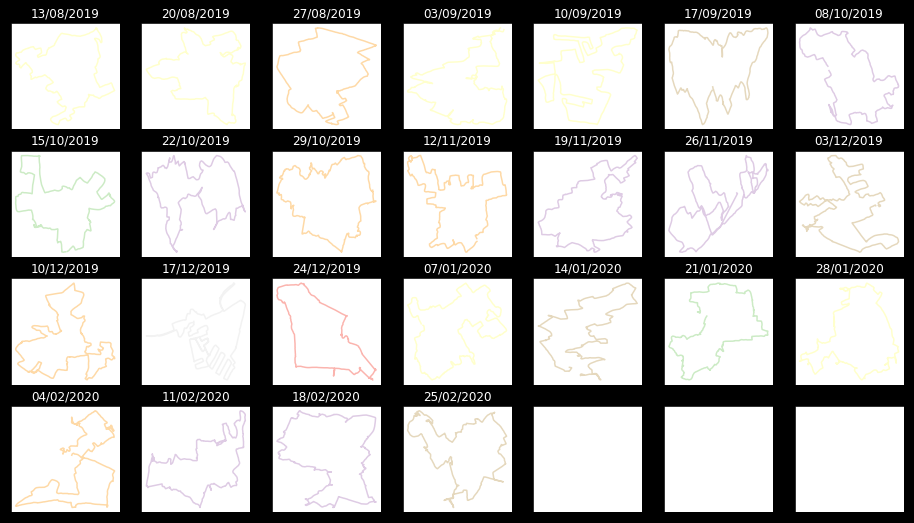

In [10]:
# Create the figure we will be plotting to, number of subplots determined previously
fig, ax = plt.subplots(int(num_rows),int(num_columns), figsize=(asp_ratio[0],asp_ratio[1]), facecolor='black')

# initialise coordinates of teh subfig we are going to be plotting the first activity to
current_row = 0
current_col = 0


for act_num in range(len(df_activities2process)): # for each individual activity
    
    
    # Open and read GPX File
    gpx_file = open(gpx_dir + df_activities2process['Filename'][act_num][:-4] + ".gpx", 'r')
    gpx_track = gpxpy.parse(gpx_file) 
    gpx_file.close()
    
    # Extract the longitude and latitude data we want to plot
    gpx = gpx_track
    
    data_iter = gpx.tracks[0].segments[0].points
    
    df_to_plot = pd.DataFrame(columns=['lon', 'lat'])
    
    
    for point in data_iter:
        df_to_plot = df_to_plot.append({'lon': point.longitude, 'lat' : point.latitude}, ignore_index=True)
   
    # Adjust longitude distance
    # The lognitudinal distance between any two points differs based where on the global we are. Therefore, 
    # adjust the longitudinal data to correct for this distortion 
    df_to_plot['adj_lon'] = np.cos(np.radians(df_to_plot.lat))*df_to_plot.lon

   
    # Normalise the graph.
    # ====================
    # each subfigure will be a square. So we need to normalise the distances of each graph so they 
    # all have the same scale (indpendent of the distance of each activity)
    
    # Compute the maximum longitude and latitude distances of the activity
    dist_long = np.abs(np.max(df_to_plot['adj_lon']) - np.min(df_to_plot['adj_lon']))
    dist_lat = np.abs(np.max(df_to_plot['lat']) - np.min(df_to_plot['lat']))
    
    # Work out which is longer (this is what we will use to normalise by)
    max_dist = np.maximum(dist_long, dist_lat)
    
    # Find the mid-point of the activity
    mid_long = np.min(df_to_plot['adj_lon']) + dist_long/2
    mid_lat = np.min(df_to_plot['lat']) + dist_lat/2
    
    # normalise the data ready to plot
    to_plot_long = (df_to_plot['adj_lon'] - (mid_long-max_dist/2)) / (mid_long+max_dist/2 - (mid_long-max_dist/2) )
    to_plot_lat = (df_to_plot['lat'] - (mid_lat-max_dist/2)) / (mid_lat+max_dist/2 - (mid_lat-max_dist/2) )
    
    
    # Plot the normalised data
    ax[current_row,current_col].plot(to_plot_long, to_plot_lat, color=cmap(norm_c_scale(colour_scale[act_num])))
    
    # Set the axis limits
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    

    # Construct subplot title
    subplot_title = '' + title_name*df_activities2process['Activity Name'][act_num] + title_name*title_date*' ' + title_date*df_activities2process['Activity Date'][act_num].strftime("%d/%m/%Y")
    
    
    ax[current_row,current_col].set_title(subplot_title, color='white')
    
    
    # having completed the iteration, iterate the coordinates of the subfigure we will plot to next iteration
    current_col = current_col+1
    
    # Make adjustment if we have to move to a new row of subplots    
    if current_col > num_columns-1: # if we reach the end of the row, reset column count to 0, and move the row count forward by 1
        current_col = 0
        current_row = current_row +1

        
# Remove axis labels etc from each subplot        
for i in range(int(num_rows)):
    for j in range(int(num_columns)):
        ax[i, j].xaxis.set_major_locator(plt.NullLocator())
        ax[i, j].yaxis.set_major_locator(plt.NullLocator())
        #ax.set_facecolor("black")
               

# Save the output as a png file as well
plt.savefig(output_dir + output_fig_name, bbox_inches='tight',facecolor=fig.get_facecolor(), transparent=True)    